In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from windrose import WindroseAxes
import seaborn as sns
import bottleneck as bn
import dataframe_image as dfi
from butterworth import butterworth

In [2]:
# netCDF files
fn1='C:\\Users\\odemeo\\Documents\\Field_Data_Processing\\CACO_MET\\Marconi\\1128\\1128wxt-a.nc'
fn2='C:\\Users\\odemeo\\Documents\\Field_Data_Processing\\CACO_MET\\Marconi\\1129A\\1129Awxt-a.nc'

# Export path
figpath1128='C:\\Users\\odemeo\\Documents\\Field_Data_Processing\\CACO_MET\\Marconi\\1128\\Figures\\'
figpath1129A='C:\\Users\\odemeo\\Documents\\Field_Data_Processing\\CACO_MET\\Marconi\\1129A\\Figures\\'

In [ ]:
# Read in mooring 1128
ds_1128 = xr.open_dataset(fn1)
ds_1128 # Marconi data when met was on solar panel
df_1128=ds_1128.to_dataframe() # Convert xarray dataset to pandas dataframe

# Make statistics table
df_stats1128=df_1128.describe()
dfi.export(df_stats1128, figpath1128+'1128_stats.png')

In [ ]:
# Put 1128 variables into arrays
time1128=ds_1128['time'].values
wdir_min1128=ds_1128['WD_min'].values
wdir_mean1128=ds_1128['WD_410'].values
wdir_max1128=ds_1128['WD_gust'].values
wsp_min1128=ds_1128['WS_min'].values
wsp_mean1128=ds_1128['WS_401'].values
wsp_max1128=ds_1128['WG_402'].values
temp1128=ds_1128['T_21'].values
relh1128=ds_1128['RH_910'].values

In [ ]:
# 1128 Time-series plots
fig, ax=plt.subplots(nrows=4, ncols=1, sharey=False, sharex=True, squeeze=True, figsize = (12,12))

# Wind speed
ax[0].plot(time1128,wsp_max1128, '.',zorder=1,label='Max')
ax[0].plot(time1128,wsp_mean1128,'-',linewidth=2,zorder=2,label='Mean')
ax[0].plot(time1128,wsp_min1128, '.',zorder=0,label='Min')
ax[0].set_ylabel('Wind speed (m/s)',fontsize=14)
ax[0].legend()
ax[0].title.set_text('1128 - Met mounted on solar panel mast')
fig.autofmt_xdate() # Rotate x-axis labels so you can read all of them
#ax[0].text(.02,.85,'Wind speed',fontsize=16,transform=ax[0].transAxes)

# Wind direction
ax[1].plot(time1128,wdir_mean1128,'m.',linewidth=2)
ax[1].set_yticks([0.,90.,180.,270,360])
ax[1].set_ylabel('Wind direction ($^{\circ}$T)',fontsize=14)
ax[1].grid(axis = 'y')
#ax[1].text(.02,.85,'Wind direction (from)',fontsize=16,transform=ax[1].transAxes)

# Temp
ax[2].plot(time1128,temp1128,'r-',linewidth=2)
ax[2].set_ylabel('Air temp. ($^{\circ}$C)',fontsize=14)
#ax[2].text(.02,.1,'Air temperature',fontsize=16,transform=ax[2].transAxes)

# Relative humidity
ax[3].plot(time1128,relh1128,'c-',linewidth=2)
ax[3].set_ylabel('Rel. humidity (%)',fontsize=14)
#ax[3].text(.02,.1,'Relative humidity',fontsize=16,transform=ax[4].transAxes)

fig.savefig(figpath1128+'1128_Time_Series')

In [ ]:
# 1128 Wind rose plot

# Mean wind dir/sp
ax=WindroseAxes.from_ax()
ax.bar(wdir_mean1128, wsp_mean1128, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
plt.title('Mean wind "from direction"')
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
#ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135)) # Add this line bc there is an error in windrose axes
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE']); # Add this line bc there is an error in windrose axes
plt.savefig(figpath1128+'1128_Windrose_Mean')

# Gust wind dir/sp
ax=WindroseAxes.from_ax()
ax.bar(wdir_max1128, wsp_max1128, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
plt.title('Gust wind "from direction"')
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
#ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135)) # Add this line bc there is an error in windrose axes
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE']); # Add this line bc there is an error in windrose axes
plt.savefig(figpath1128+'1128_Windrose_Gust')

In [ ]:
# Compute joint-probability

# Mean wind dir/sp
df_wind_mean=pd.DataFrame({'mean_windsp': wsp_mean1128, 'mean_winddir': wdir_mean1128})
sns.jointplot(data=df_wind_mean, x="mean_winddir", y="mean_windsp", bins=36, kind="hist", marginal_kws=dict(bins=36))
plt.savefig(figpath1128+'1128_JointProb_Mean')

# Gust wind dir/sp
df_wind_gust=pd.DataFrame({'gust_windsp': wsp_max1128, 'gust_winddir': wdir_max1128})
sns.jointplot(data=df_wind_gust, x="gust_winddir", y="gust_windsp", bins=36, kind="hist", marginal_kws=dict(bins=36))
plt.savefig(figpath1128+'1128_JointProb_Gust')

In [ ]:
# Stick plots

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_mean = -wsp_mean1128 * np.sin(np.radians(wdir_mean1128))
v_mean = -wsp_mean1128 * np.cos(np.radians(wdir_mean1128))

props = {'units' : "dots",
    'width' : 0.008,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1128, [[0]*len(time1128)] , u_mean, v_mean, angles='uv', **props)
plt.xticks(rotation=70)
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Mean wind "to direction"')

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_max = -wsp_max1128 * np.sin(np.radians(wdir_max1128))
v_max = -wsp_max1128 * np.cos(np.radians(wdir_max1128))

props = {'units' : "dots",
    'width' : 0.008,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1128, [[0]*len(time1128)] , u_max, v_max, angles='uv', **props)
plt.xticks(rotation=70)
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Gust wind "to direction"');

In [ ]:
# Stick plots of rolling average

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_mean = -wsp_mean1128 * np.sin(np.radians(wdir_mean1128))
v_mean = -wsp_mean1128 * np.cos(np.radians(wdir_mean1128))

# Calculate rolling average of wind components
u_mean_roll=bn.move_mean(u_mean, window=61) # Returns same length with NaNs at beginning
v_mean_roll=bn.move_mean(v_mean, window=61)

# Get hourly samples: Start at 60 and grab every 60 values since samples are on the minute
u_mean_hourly=u_mean_roll[60::60] 
v_mean_hourly=v_mean_roll[60::60]
time1128_hourly=time1128[60::60]

props = {'units' : "dots",
    'width' : 0.3,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1128_hourly, [[0]*len(time1128_hourly)] , u_mean_hourly, v_mean_hourly, angles='uv', **props)
fig.autofmt_xdate()
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Mean wind "to direction"')
plt.savefig(figpath1128+'1128_StickRollAvg_Mean')

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_max = -wsp_max1128 * np.sin(np.radians(wdir_max1128))
v_max = -wsp_max1128 * np.cos(np.radians(wdir_max1128))

# Calculate rolling average of wind components
u_max_roll=bn.move_mean(u_max, window=61) # Returns same length with NaNs at beginning
v_max_roll=bn.move_mean(v_max, window=61)

# Get hourly samples: Start at 60 and grab every 60 values since samples are on the minute
u_max_hourly=u_max_roll[60::60] 
v_max_hourly=v_max_roll[60::60]
time1128_hourly=time1128[60::60]

props = {'units' : "dots",
    'width' : 0.3,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1128_hourly, [[0]*len(time1128_hourly)] , u_max_hourly, v_max_hourly, angles='uv', **props)
fig.autofmt_xdate()
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Gust wind "to direction"');
plt.savefig(figpath1128+'1128_StickRollAvg_Gust')

In [ ]:
# Stick plots with butterworth filter

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_mean = -wsp_mean1128 * np.sin(np.radians(wdir_mean1128))
v_mean = -wsp_mean1128 * np.cos(np.radians(wdir_mean1128))

# Butterworth low-pass filter
u_mean_filt=butterworth(u_mean, 60, 2, 13)
v_mean_filt=butterworth(v_mean, 60, 2, 13)

props = {'units' : "dots",
    'width' : 0.003,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1128, [[0]*len(time1128)] , u_mean_filt, v_mean_filt, angles='uv', **props)
fig.autofmt_xdate()
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Mean wind "to direction"')
plt.savefig(figpath1128+'1128_StickButterFilt_Mean')

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_max = -wsp_max1128 * np.sin(np.radians(wdir_max1128))
v_max = -wsp_max1128 * np.cos(np.radians(wdir_max1128))

# Butterworth low-pass filter
u_max_filt=butterworth(u_max, 60, 2, 13)
v_max_filt=butterworth(v_max, 60, 2, 13)

props = {'units' : "dots",
    'width' : 0.003,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1128, [[0]*len(time1128)] , u_max_filt, v_max_filt, angles='uv', **props)
fig.autofmt_xdate()
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Gust wind "to direction"')
plt.savefig(figpath1128+'1128_StickButterFilt_Gust')

In [3]:
# Read in mooring 1129A
ds_1129A = xr.open_dataset(fn2)
ds_1129A # Marconi data after met was transferred to its own pole
df_1129A=ds_1129A.to_dataframe() # Convert xarray dataset to pandas dataframe

# Make statistics table 
df_stats1129A=df_1129A.describe()
dfi.export(df_stats1129A, figpath1129A+'1129A_stats.png')

In [4]:
# Put 1129A variables into arrays
time1129A=ds_1129A['time'].values
wdir_min1129A=ds_1129A['WD_min'].values
wdir_mean1129A=ds_1129A['WD_410'].values
wdir_max1129A=ds_1129A['WD_gust'].values
wsp_min1129A=ds_1129A['WS_min'].values
wsp_mean1129A=ds_1129A['WS_401'].values
wsp_max1129A=ds_1129A['WG_402'].values
temp1129A=ds_1129A['T_21'].values
relh1129A=ds_1129A['RH_910'].values

In [ ]:
# 1129A Time-series plots
fig, ax=plt.subplots(nrows=4, ncols=1, sharey=False, sharex=True, squeeze=True, figsize = (12,12))

# Wind speed
ax[0].plot(time1129A,wsp_max1129A, '.',zorder=1,label='Max')
ax[0].plot(time1129A,wsp_mean1129A,'-',linewidth=2,zorder=2,label='Mean')
ax[0].plot(time1129A,wsp_min1129A, '.',zorder=0,label='Min')
ax[0].set_ylabel('Wind speed (m/s)',fontsize=14)
ax[0].legend()
ax[0].title.set_text('1129A')
fig.autofmt_xdate() # Rotate x-axis labels so you can read all of them
#ax[0].text(.02,.85,'Wind speed',fontsize=16,transform=ax[0].transAxes)

# Wind direction
ax[1].plot(time1129A,wdir_mean1129A,'m.',linewidth=2)
ax[1].set_yticks([0.,90.,180.,270,360])
ax[1].set_ylabel('Wind direction ($^{\circ}$T)',fontsize=14)
ax[1].grid(axis = 'y')
#ax[1].text(.02,.85,'Wind direction (from)',fontsize=16,transform=ax[1].transAxes)

# Temp
ax[2].plot(time1129A,temp1129A,'r-',linewidth=2)
ax[2].set_ylabel('Air temp. ($^{\circ}$C)',fontsize=14)
#ax[2].text(.02,.1,'Air temperature',fontsize=16,transform=ax[2].transAxes)

# Relative humidity
ax[3].plot(time1129A,relh1129A,'c-',linewidth=2)
ax[3].set_ylabel('Rel. humidity (%)',fontsize=14)
#ax[3].text(.02,.1,'Relative humidity',fontsize=16,transform=ax[4].transAxes)

fig.savefig(figpath1129A+'1129A_Time_Series')


In [ ]:
# 1129A Wind rose plot

# Mean wind dir/sp
ax=WindroseAxes.from_ax()
ax.bar(wdir_mean1129A, wsp_mean1129A, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
plt.title('Mean wind "from direction"')
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
#ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135)) # Add this line bc there is an error in windrose axes
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE']); # Add this line bc there is an error in windrose axes
plt.savefig(figpath1129A+'1129A_Windrose_Mean')

# Gust wind dir/sp
ax=WindroseAxes.from_ax()
ax.bar(wdir_max1129A, wsp_max1129A, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
plt.title('Gust wind "from direction"')
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
#ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135)) # Add this line bc there is an error in windrose axes
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE']); # Add this line bc there is an error in windrose axes
plt.savefig(figpath1129A+'1129A_Windrose_Gust')

In [ ]:
# Compute joint-probability

# Mean wind dir/sp
df_wind_mean=pd.DataFrame({'mean_windsp': wsp_mean1129A, 'mean_winddir': wdir_mean1129A})
sns.jointplot(data=df_wind_mean, x="mean_winddir", y="mean_windsp", bins=36, kind="hist", marginal_kws=dict(bins=36))
plt.savefig(figpath1129A+'1129A_JointProb_Mean')

# Gust wind dir/sp
df_wind_gust=pd.DataFrame({'gust_windsp': wsp_max1129A, 'gust_winddir': wdir_max1129A})
sns.jointplot(data=df_wind_gust, x="gust_winddir", y="gust_windsp", bins=36, kind="hist", marginal_kws=dict(bins=36))
plt.savefig(figpath1129A+'1129A_JointProb_Gust')

In [ ]:
# Stick plots

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_mean = -wsp_mean1129A * np.sin(np.radians(wdir_mean1129A))
v_mean = -wsp_mean1129A * np.cos(np.radians(wdir_mean1129A))

props = {'units' : "dots",
    'width' : 0.003,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1129A, [[0]*len(time1129A)] , u_mean, v_mean, angles='uv', **props)
plt.xticks(rotation=70)
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Mean wind "to direction"')

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_max = -wsp_max1129A * np.sin(np.radians(wdir_max1129A))
v_max = -wsp_max1129A * np.cos(np.radians(wdir_max1129A))

props = {'units' : "dots",
    'width' : 0.003,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1129A, [[0]*len(time1129A)] , u_max, v_max, angles='uv', **props)
plt.xticks(rotation=70)
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Gust wind "to direction"');

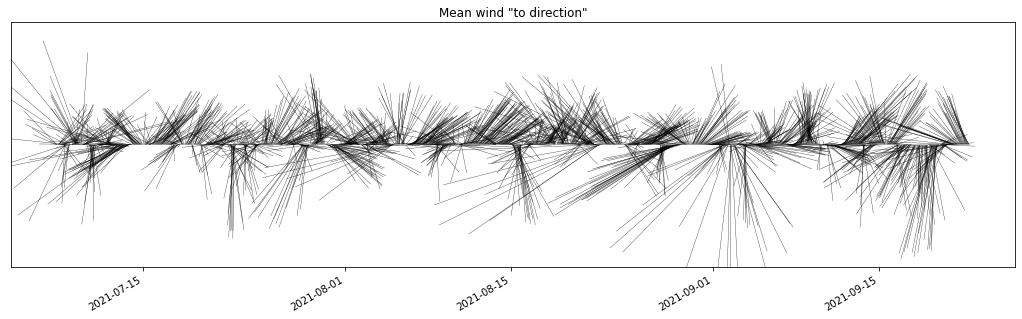

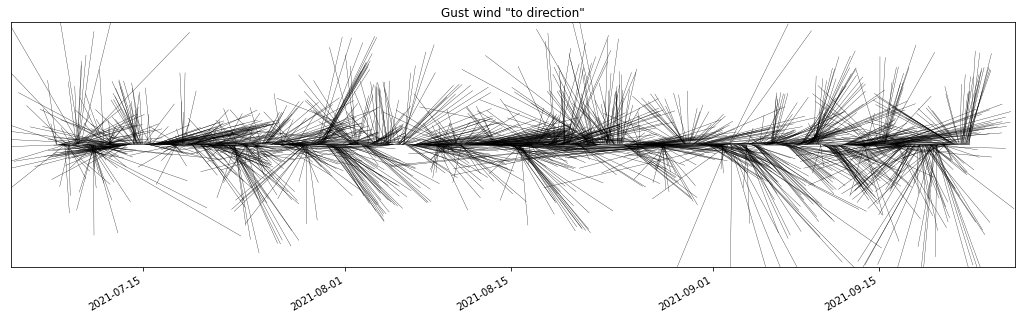

In [55]:
# Stick plots of rolling average

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_mean = -wsp_mean1129A * np.sin(np.radians(wdir_mean1129A))
v_mean = -wsp_mean1129A * np.cos(np.radians(wdir_mean1129A))

# Calculate rolling average of wind components
u_mean_roll=bn.move_mean(u_mean, window=61) # Returns same length with NaNs at beginning
v_mean_roll=bn.move_mean(v_mean, window=61)

# Get hourly samples: Start at 60 and grab every 60 values since samples are on the minute
u_mean_hourly=u_mean_roll[60::60] 
v_mean_hourly=v_mean_roll[60::60]
time1129A_hourly=time1129A[60::60]

props = {'units' : "dots",
    'width' : 0.3,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))

qiv = ax.quiver(time1129A_hourly, [0]*len(time1129A_hourly), u_mean_hourly, v_mean_hourly, angles='uv', **props)
fig.autofmt_xdate()
ax.axes.yaxis.set_visible(False)
plt.title('Mean wind "to direction"')
plt.savefig(figpath1129A+'1129A_StickRollAvg_Mean')

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_max = -wsp_max1129A * np.sin(np.radians(wdir_max1129A))
v_max = -wsp_max1129A * np.cos(np.radians(wdir_max1129A))

# Calculate rolling average of wind components
u_max_roll=bn.move_mean(u_max, window=61) # Returns same length with NaNs at beginning
v_max_roll=bn.move_mean(v_max, window=61)

# Get hourly samples: Start at 60 and grab every 60 values since samples are on the minute
u_max_hourly=u_max_roll[60::60] 
v_max_hourly=v_max_roll[60::60]
time1129A_hourly=time1129A[60::60]

props = {'units' : "dots",
    'width' : 0.3,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1129A_hourly, [0]*len(time1129A_hourly) , u_max_hourly, v_max_hourly, angles='uv', **props)
fig.autofmt_xdate()
ax.axes.yaxis.set_visible(False)
plt.title('Gust wind "to direction"');
plt.savefig(figpath1129A+'1129A_StickRollAvg_Gust')

In [ ]:
# Stick plots with butterworth filter

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_mean = -wsp_mean1129A * np.sin(np.radians(wdir_mean1129A))
v_mean = -wsp_mean1129A * np.cos(np.radians(wdir_mean1129A))

# Butterworth low-pass filter
u_mean_filt=butterworth(u_mean, 60, 2, 13)
v_mean_filt=butterworth(v_mean, 60, 2, 13)

props = {'units' : "dots",
    'width' : 0.003,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1129A, [[0]*len(time1129A)] , u_mean_filt, v_mean_filt, angles='uv', **props)
fig.autofmt_xdate()
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Mean wind "to direction"')
plt.savefig(figpath1129A+'1129A_StickButterFilt_Mean')

# Calculate wind components from speed and metereological wind direction (wind from direction)
u_max = -wsp_max1129A * np.sin(np.radians(wdir_max1129A))
v_max = -wsp_max1129A * np.cos(np.radians(wdir_max1129A))

# Butterworth low-pass filter
u_max_filt=butterworth(u_max, 60, 2, 13)
v_max_filt=butterworth(v_max, 60, 2, 13)

props = {'units' : "dots",
    'width' : 0.003,
    'headwidth': 0,
    'headlength': 0,
    'headaxislength': 0,
    'scale' : .08
        }
fig, ax = plt.subplots(figsize=(18, 5))
qiv = ax.quiver(time1129A, [[0]*len(time1129A)] , u_max_filt, v_max_filt, angles='uv', **props)
fig.autofmt_xdate()
plt.setp(ax.get_yticklabels(), visible=False)
plt.title('Gust wind "to direction"')
plt.savefig(figpath1129A+'1129A_StickButterFilt_Gust')